In [118]:
####################################################################################
### Import Packages ### run in tfp environment: 
####################################################################################

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import os 
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow.python.keras.optimizer_v2.adam import Adam
tfd = tfp.distributions
import tensorflow.keras.backend as K
from tensorflow import math as tfm

import os
import utilsProb
import utilsProbSS
import glob
import sys
from scipy.stats import rankdata
import pandas as pd
import importlib
import copy
from netCDF4 import Dataset, num2date
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
import properscoring as ps
from math import erf
import xarray as xr
import matplotlib

import numpy.matlib
import Unet_b
import utils_CNN
import coms
import comsnn

from tensorflow.python.client import device_lib
####################################################################################
####################################################################################
import utils_verif
import seaborn as sns

### set seeds

In [119]:
#set seeds
tf.random.set_seed(33) #patrick roy's number.
np.random.seed(33) #set numpy seed 

## Color Palette

In [120]:
SScolors = {'CNN':[0,0,0],
            'NN': [0.530026912725875, 0.7456362937331797, 0.8560553633217994],
            '$AnEn$': [0.1843137254901961, 0.47266435986159167, 0.7116493656286044],
            'FCN': [0.0196078431372549, 0.18823529411764706, 0.3803921568627451]}


In [95]:
stepnum= 13
dirA = ['F'+f'{x:03}' for x in np.arange(0,126,6)]
print('#############################################')
print('post processing forecast:', dirA[stepnum-1])
print('#############################################')

##################

#############################################
post processing forecast: F072
#############################################


## Run Permute Data Step: CNN

In [106]:
stepnum= 17
dirA = ['F'+f'{x:03}' for x in np.arange(0,126,6)]
print('#############################################')
print('post processing forecast:', dirA[stepnum-1])
print('#############################################')

####################################################################################
#GPU cuda handling: 
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

os.environ["CUDA_VISIBLE_DEVICES"]="0"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('#################################################')
    print('#################################################')
    print('WARNING: GPU device not found.')
    print('#################################################')
    print('#################################################')
else:
    print('#################################################')
    print('#################################################')
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))
    print('#################################################')
    print('#################################################')
####################################################################################
print('We are here:',os.getcwd())
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')


####################################################################################
# check region of interest folder
####################################################################################

latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
lat = np.arange(22,60.5,.5)
lon = np.arange(200.0,249.375+.625,.625)
MapPoints = np.zeros([lat.shape[0],lon.shape[0]])
print('...Searching...:',latlonfolder)
path = latlonfolder
pp_file_names = [f for f in glob.glob(path + "/lat*lon*", recursive=True)]
pp_file_names = sorted(pp_file_names)
####################################################################################
####################################################################################

dd = '/glade/scratch/wchapman/Reforecast/'
os.chdir(dd)

yago= next(os.walk('.'))[1]
yago = sorted(yago)
subs = 'F'
res = [ii for ii in yago if subs in ii] 
res
for fcast in res[:stepnum]: 
    os.chdir(dd+'/'+fcast)
    print(os.getcwd())
    
####################################################################################
####################################################################################

batch_num = 50
epochs = 30
#find all files in directory                                                                                                                                                  
print('Training on')
path = os.getcwd()
train_file_names = sorted([f for f in glob.glob(path + "/train/*_500mb_Clean.nc", recursive=True)])
for f in train_file_names:
    print(f)

print('Validating on')
validate_file_names = sorted([f for f in glob.glob(path + "/validate/*_500mb_Clean.nc", recursive=True)])
for f in validate_file_names:
    print(f)
    
print('Testing on')
test_file_names = sorted([f for f in glob.glob(path + "/test/*_500mb_Clean.nc", recursive=True)])
for f in test_file_names:
    print(f)
    
All_file_names =train_file_names + validate_file_names +test_file_names 


####################################################################################
####################################################################################


yearstoinclude = ['1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005',
                  '2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
res=[]
for jj in yearstoinclude:
    res.append([i for i in All_file_names if jj in i][0])
    
print('trainging yearss',res)

####################################################################################
# normalization dictionaries
####################################################################################
norm_dict = utils_CNN.get_image_normalization_params(res)
sys.stdout.flush()
norm_dict_targ = utils_CNN.get_image_normalization_params_targ(res)
norm_dict_targ['IVTm'][0]=0
norm_dict_targ['IVTm'][1]=1

All_file_names
allinds = np.arange(len(res))

ense = 21
numbins = 15
allinds = np.arange(len(All_file_names))


avgvar_mA = np.zeros([len(All_file_names),numbins])
msebin_mA = np.zeros([len(All_file_names),numbins])
avgvar_sA = np.zeros([len(All_file_names),numbins])
msebin_sA = np.zeros([len(All_file_names),numbins])

mAl =np.array([])
sAl =np.array([])
yAl =np.array([])
wwrfAl = np.array([])
latoutAl = np.array([])
lonoutAl = np.array([])
tout = np.array([],dtype='datetime64[ns]')

print('######### ASSEMBLE!!!! ###########')
#find lat/lons of interest:
rang = 144
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind, lonind] = utilsProbSS.get_latlon_ind(latlonfolder)
latsDO.shape
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])
print('########### DONE!!!! #############')

#permute by variable!
for permperm in range(7):
    allinds = np.arange(len(All_file_names))
    avgvar_mA = np.zeros([len(All_file_names),numbins])
    msebin_mA = np.zeros([len(All_file_names),numbins])
    avgvar_sA = np.zeros([len(All_file_names),numbins])
    msebin_sA = np.zeros([len(All_file_names),numbins])

    mAl =np.array([])
    sAl =np.array([])
    yAl =np.array([])
    wwrfAl = np.array([])
    latoutAl = np.array([])
    lonoutAl = np.array([])
    tout = np.array([],dtype='datetime64[ns]')
    
    for ddfa, bb in enumerate(range(len(res)-3,len(res))):

        if bb == (len(res)-1):
            allinds = np.arange(len(res))
            test_fil_name = [res[allinds[-3]]]
            val_fil_name = [res[allinds[-1]]]
            rest = np.delete(allinds,[bb,bb+1])
            train_fil_name = np.array(res)[rest].tolist()
        else:
            allinds = np.arange(len(res))
            test_fil_name = [res[allinds[bb+1]]]
            val_fil_name = [res[allinds[bb]]]
            rest = np.delete(allinds,[bb,bb+1])
            train_fil_name = np.array(res)[rest].tolist()

        print('#################################################')
        print('testing:',test_fil_name)
        print('validatiing:',val_fil_name)
        print('#################################################')

        num_samps_train = utilsProb.count_samps(train_fil_name)
        num_samps_val = utilsProb.count_samps(val_fil_name)

        print('...gathering data...')
        aa = utils_CNN.deep_learning_generator(train_fil_name, num_samps_train,norm_dict,norm_dict_targ)
        adf = next(aa)
        x = adf[0]
        y = adf[1]

        aa = utils_CNN.deep_learning_generator_nordnm(test_fil_name, num_samps_val,norm_dict,norm_dict_targ)
        adf = next(aa)
        x_tst = adf[0]
        y_tst = adf[1]
        
        
        if permperm > 0: 
            print('permution variable number:', permperm-1)
            ### shuffle a single dimension ####
            shuff_x = x_tst[:,:,:,permperm-1].squeeze()
            np.random.shuffle(shuff_x)
            x_tst[:,:,:,permperm-1] = shuff_x
        
        
    #     ### Model Build #### 
        img_height = x.shape[1]
        img_width = x.shape[2]
        num_channels = x.shape[3]
        img_shape = (img_height, img_width, num_channels)
        nummy_classes = 2

        model = Unet_b.model_simple_unet_initializer(img_shape=img_shape, cost_func=coms.crps_cost_function,num_classes=nummy_classes,num_levels = 1,num_layers =2, num_bottleneck = 3, filter_size_start =16, batch_norm=None, kernel_size = 3, 
                                         bottleneck_dilation = True, bottleneck_sum_activation =False)

        valyr= val_fil_name[0].split('_500mb')[0]
        valyr =valyr.split('_')[2]
        tstyr= test_fil_name[0].split('_500mb')[0]
        tstyr =tstyr.split('_')[2]
    #     #save location:
        newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/CNN_'+tstyr
        if not os.path.exists(newdir):
            os.makedirs(newdir)

        Wsave_name = newdir+'/cpf_CRPS_FINETUNE_val_'+ valyr+'_test_'+tstyr+'.ckpt'

        print('########### model name:',Wsave_name)
        print('########### model name:',Wsave_name)

        ### CHANGE THIS FOR PRODUCTION RUNS ###########
        model.load_weights(Wsave_name).expect_partial()
        ### CHANGE THIS FOR PRODUCTION RUNS ###########

        yhat = model(x_tst)
        yhat = yhat.numpy()

        m = np.ndarray.flatten(yhat[:,latind,lonind,0],order='F')
        m2 = np.ndarray.flatten(yhat[:,latind,lonind,0],order='F')
        mm = np.ndarray.flatten(yhat[:,latind,lonind,0],order='F')
        s = np.abs(np.ndarray.flatten(yhat[:,latind,lonind,1],order='F'))

        WWRF = utilsProbSS.denormalize_images_targ((x_tst[:,:,:,0]),'IVT',norm_dict)
        WWRF = np.ndarray.flatten(WWRF[:,latind,lonind],order='F')

        y_tst = (utilsProbSS.denormalize_images_targ(np.ndarray.flatten(y_tst[:,latind,lonind,0],order='F'),'IVTm',norm_dict_targ))
        y_tst=np.expand_dims(y_tst,axis=1)

        #gather other variables of interest (time and lat/lon)
        op = xr.open_dataset(test_fil_name[0])
        lat = op['lat'][:].data
        lon = op['lon'][:].data
        lat_out = np.ndarray.flatten(np.matlib.repmat(lat[latind],x_tst.shape[0],1),order='F')
        lon_out = np.ndarray.flatten(np.matlib.repmat(lon[lonind],x_tst.shape[0],1),order='F')
        time_out = np.ndarray.flatten(np.matlib.repmat(op['time'][:].data,latind.shape[0],1)) 


        #form ensembles 
        m_All = np.zeros(len(m))
        sss_All = np.zeros([len(m),ense])
        s_All = np.zeros(len(m))


        for ii in range(len(m)):
            sss = np.random.normal(m[ii],s[ii],ense)
            sln=np.std(sss)
            mln=np.mean(sss)
            [mln,sln]=coms.lognstat(m[ii],s[ii])
            s_All[ii]=s[ii]
            m_All[ii]=m[ii]
            sss_All[ii,:] =(sss) 

        m = m_All
        m[np.isnan(m)]=0
        s=s_All
        s[np.isnan(m)]=0

        y_tst = (y_tst)
        WWRF = (WWRF)
        distPP = s

        if ddfa == 0:
            sssAl = sss_All
        else: 
            sssAl = np.concatenate([sssAl,sss_All],axis=0)

        if bb == (len(res)-1):
            mAl = np.append(np.ndarray.flatten(m),mAl)
            yAl = np.append(np.ndarray.flatten(y_tst),yAl)
            sAl = np.append(np.ndarray.flatten(s),sAl)
            wwrfAl = np.append(np.ndarray.flatten(WWRF),wwrfAl)
            latoutAl = np.append(np.ndarray.flatten(lat_out),latoutAl)
            lonoutAl = np.append(np.ndarray.flatten(lon_out),lonoutAl)
            tout = np.append(np.ndarray.flatten(time_out),tout)
        else:
            mAl = np.append(mAl,np.ndarray.flatten(m))
            yAl = np.append(yAl,np.ndarray.flatten(y_tst))
            sAl = np.append(sAl,np.ndarray.flatten(s))
            wwrfAl = np.append(wwrfAl,np.ndarray.flatten(WWRF))
            latoutAl = np.append(latoutAl,np.ndarray.flatten(lat_out))
            lonoutAl = np.append(lonoutAl,np.ndarray.flatten(lon_out))
            tout = np.append(tout,np.ndarray.flatten(time_out))

        print('...binned spread skill...')
        [avgvar_m,msebin_m,avgvar_s,msebin_s]=coms.spreadskill(m,y_tst,distPP,numbins)

        avgvar_mA[bb,:] = np.squeeze(avgvar_m)
        msebin_mA[bb,:] = np.squeeze(msebin_m)
        avgvar_sA[bb,:] = np.squeeze(avgvar_s)
        msebin_sA[bb,:] = np.squeeze(msebin_s)

        print('RMSE PP:',coms.rmse(np.expand_dims(m,axis=1),y_tst))
        print('RMSE WWRF:',coms.rmse(np.expand_dims(WWRF,axis=1),y_tst))
        print('CRMSE PP:',coms.crmse(np.expand_dims(m,axis=1),y_tst))
        print('CRMSE WWRF:',coms.crmse(np.expand_dims(WWRF,axis=1),y_tst))
        print('BIAS PP:',coms.bias(np.expand_dims(m,axis=1),y_tst))
        print('BIAS WWRF:',coms.bias(np.expand_dims(WWRF,axis=1),y_tst))

    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Reforecast_out/'
    print('IVTm shape:', yAl.shape)
    print('IVT mean shape:', mAl.shape)
    print('IVT std shape:', sAl.shape)

    df_out = pd.DataFrame({'time':tout,'OBS':yAl,'Model':wwrfAl,'IVTmean':mAl,'IVTstd':sAl,'lat':latoutAl,'lon':lonoutAl})

    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Reforecast_out/'
    print('IVTm shape:', yAl.shape)
    print('IVT mean shape:', mAl.shape)
    print('IVT std shape:', sAl.shape)

    df_out = pd.DataFrame({'time':tout,'OBS':yAl,'Model':wwrfAl,'IVTmean':mAl,'IVTstd':sAl,'lat':latoutAl,'lon':lonoutAl})
    pkl_save = newdir+'NN_CRPS_CNNPP_FINETUNE_permute_' +f'{permperm:03}'+ '.pkl'
    df_out.to_pickle(pkl_save)

#############################################
post processing forecast: F096
#############################################
[]
#################################################
#################################################
#################################################
#################################################
We are here: /glade/scratch/wchapman/Reforecast/F072
...Searching...: /glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/
/glade/scratch/wchapman/Reforecast/F000
/glade/scratch/wchapman/Reforecast/F006
/glade/scratch/wchapman/Reforecast/F012
/glade/scratch/wchapman/Reforecast/F018
/glade/scratch/wchapman/Reforecast/F024
/glade/scratch/wchapman/Reforecast/F030
/glade/scratch/wchapman/Reforecast/F036
/glade/scratch/wchapman/Reforecast/F042
/glade/scratch/wchapman/Reforecast/F048
/glade/scratch/wchapman/Reforecast/F054
/glade/scratch/wchapman/Reforecast/F060
/glade/scratch/wchapman/Reforecast/F066
/glade/scratch/wchapman/Reforecast/F072
/glade/scratch/wchapman/Reforec

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2010_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1999_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2009_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2007_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 75.44911021581653
RMSE WWRF: 81.39519708806819
CRMSE PP: 75.33284605460744
CRMSE WWRF: 81.35976710464016
BIAS PP: -4.186953285289974
BIAS WWRF: 2.4012146
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2010_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2002_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2004_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2009_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2006_500mb_Clean.nc"

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 77.21333806385682
RMSE WWRF: 84.77367424242425
CRMSE PP: 76.49463818012487
CRMSE WWRF: 84.67151988636364
BIAS PP: -10.510464423287345
BIAS WWRF: -4.1605988
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1998_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc".

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 88.02702314556485
RMSE WWRF: 91.40266187263258
CRMSE PP: 87.53748759704206
CRMSE WWRF: 91.33556019176136
BIAS PP: -9.270659227180744
BIAS WWRF: -3.5017395
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2007_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2009_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2005_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2011_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2000_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2012_500mb_Clean.nc"...

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 133.60327240495317
RMSE WWRF: 168.77923768939394
CRMSE PP: 133.59114380515194
CRMSE WWRF: 168.76214784564394
BIAS PP: -1.800192622551691
BIAS WWRF: 2.4011993
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2007_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2000_500mb_Clean.nc"

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 129.59593214212842
RMSE WWRF: 167.50358072916666
CRMSE PP: 129.19093895241755
CRMSE WWRF: 167.45189689867425
BIAS PP: -10.23752970559758
BIAS WWRF: -4.160614
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2005_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2012_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2006_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1998_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2003_500mb_Clean.nc".

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 162.620491181494
RMSE WWRF: 209.04557291666666
CRMSE PP: 162.3925192009977
CRMSE WWRF: 209.01624644886363
BIAS PP: -8.607781988858534
BIAS WWRF: -3.5017548
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2003_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2006_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2000_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2008_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 75.31063305980547
RMSE WWRF: 81.39519708806819
CRMSE PP: 75.20010165430764
CRMSE WWRF: 81.35976710464016
BIAS PP: -4.078749993013844
BIAS WWRF: 2.4012146
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2004_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2005_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2006_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2009_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 77.17596596607025
RMSE WWRF: 84.77367424242425
CRMSE PP: 76.43036595877506
CRMSE WWRF: 84.67151988636364
BIAS PP: -10.701814615474689
BIAS WWRF: -4.1605988
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2014_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2011_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2008_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2013_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2006_500mb_Clean.nc".

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 88.11451151687038
RMSE WWRF: 91.40266187263258
CRMSE PP: 87.59298409889536
CRMSE WWRF: 91.33556019176136
BIAS PP: -9.572686763177558
BIAS WWRF: -3.5017395
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2003_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2005_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2007_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1999_500mb_Clean.nc"...

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 76.21114011861849
RMSE WWRF: 81.39519708806819
CRMSE PP: 76.12417521833615
CRMSE WWRF: 81.35976710464016
BIAS PP: -3.6397606911628486
BIAS WWRF: 2.4012146
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2012_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1999_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2009_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 78.1389900879816
RMSE WWRF: 84.77367424242425
CRMSE PP: 77.39364080117342
CRMSE WWRF: 84.67151988636364
BIAS PP: -10.766898037371448
BIAS WWRF: -4.1605988
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2013_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2000_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2001_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc".

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 89.91212759030405
RMSE WWRF: 91.40266187263258
CRMSE PP: 89.44640806943016
CRMSE WWRF: 91.33556019176136
BIAS PP: -9.139519902957034
BIAS WWRF: -3.5017395
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2010_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2000_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2004_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2002_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2012_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1998_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 75.99911407484056
RMSE WWRF: 81.39519708806819
CRMSE PP: 75.80633938949424
CRMSE WWRF: 81.35976710464016
BIAS PP: -5.409649468650514
BIAS WWRF: 2.4012146
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2006_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1998_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2003_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2008_500mb_Clean.nc"

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 78.77812271636498
RMSE WWRF: 84.77367424242425
CRMSE PP: 77.91371530691453
CRMSE WWRF: 84.67151988636364
BIAS PP: -11.63810665947895
BIAS WWRF: -4.1605988
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2014_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2000_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2001_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2003_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc".

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 89.09237364321609
RMSE WWRF: 91.40266187263258
CRMSE PP: 88.48294599278773
CRMSE WWRF: 91.33556019176136
BIAS PP: -10.402853941786049
BIAS WWRF: -3.5017395
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2008_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2009_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2011_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2010_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 75.35223388638305
RMSE WWRF: 81.39519708806819
CRMSE PP: 75.20353558554984
CRMSE WWRF: 81.35976710464016
BIAS PP: -4.731536307282369
BIAS WWRF: 2.4012146
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2013_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2003_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2000_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 78.02388684183805
RMSE WWRF: 84.77367424242425
CRMSE PP: 77.2125438939055
CRMSE WWRF: 84.67151988636364
BIAS PP: -11.222741487159766
BIAS WWRF: -4.1605988
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2009_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2007_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2001_500mb_Clean.n

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 88.18274375005709
RMSE WWRF: 91.40266187263258
CRMSE PP: 87.72148606640249
CRMSE WWRF: 91.33556019176136
BIAS PP: -9.00762064759067
BIAS WWRF: -3.5017395
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1999_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2010_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2014_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 77.02234491288793
RMSE WWRF: 81.39519708806819
CRMSE PP: 76.86045253517644
CRMSE WWRF: 81.35976710464016
BIAS PP: -4.991242853734775
BIAS WWRF: 2.4012146
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2015_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2005_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2006_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 80.66884327740472
RMSE WWRF: 84.77367424242425
CRMSE PP: 79.77471821699623
CRMSE WWRF: 84.67151988636364
BIAS PP: -11.97733518527778
BIAS WWRF: -4.1605988
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1985_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1986_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1987_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1998_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2005_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2002_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2011_500mb_Clean.nc".

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:491: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/coms.py:492: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 92.94500077033499
RMSE WWRF: 91.40266187263258
CRMSE PP: 92.3986333916592
CRMSE WWRF: 91.33556019176136
BIAS PP: -10.063089687688517
BIAS WWRF: -3.5017395
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)


## Run Permute Data Step: NN

In [107]:
####################################################################################
####################################################################################
dirA = ['F'+f'{x:03}' for x in np.arange(0,126,6)]
print('#############################################')
print('post processing forecast:', dirA[stepnum-1])
print('#############################################')

#####################################################################################
#GPU cuda handling: 
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('#################################################')
    print('#################################################')
    print('WARNING: GPU device not found.')
    print('#################################################')
    print('#################################################')
else:
    print('#################################################')
    print('#################################################')
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))
    print('#################################################')
    print('#################################################')
####################################################################################
print('We are here:',os.getcwd())
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')


####################################################################################
# check region of interest folder
####################################################################################

dd = '/glade/scratch/wchapman/Reforecast/'
os.chdir(dd)

yago= next(os.walk('.'))[1]
yago = sorted(yago)
subs = 'F'
res = [ii for ii in yago if subs in ii] 
res
for fcast in res[:stepnum]: 
    os.chdir(dd+'/'+fcast)
    print(os.getcwd())
    
    
####################################################################################
####################################################################################    
    
batch_num = 50
epochs = 30
#find all files in directory                                                                                                                                                  
print('Training on')
path = os.getcwd()
train_file_names = sorted([f for f in glob.glob(path + "/train/*_500mb_Clean.nc", recursive=True)])
for f in train_file_names:
    print(f)

print('Validating on')
validate_file_names = sorted([f for f in glob.glob(path + "/validate/*_500mb_Clean.nc", recursive=True)])
for f in validate_file_names:
    print(f)
    
print('Testing on')
test_file_names = sorted([f for f in glob.glob(path + "/test/*_500mb_Clean.nc", recursive=True)])
for f in test_file_names:
    print(f)
    
All_file_names =train_file_names + validate_file_names +test_file_names 

####################################################################################
#years to include in training. 
####################################################################################
# yearstoinclude = ['1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005',
#                   '2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
yearstoinclude = ['2016','2017','2018']
res=[]
for jj in yearstoinclude:
    res.append([i for i in All_file_names if jj in i][0])
    
print(res)

####################################################################################
#region: 
####################################################################################

rang = 144
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind, lonind] = utilsProbSS.get_latlon_ind(latlonfolder)
latsDO.shape
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])

norm_dict = utilsProbSS.get_image_normalization_params(res,latind,lonind)
sys.stdout.flush()
norm_dict_targ = utilsProbSS.get_image_normalization_params_targ(res,latind,lonind)

#no scaling the target
norm_dict_targ['IVTm'][0]=0
norm_dict_targ['IVTm'][1]=1

sys.stdout.flush()
num_samps_train = utilsProb.count_samps(train_file_names)
num_samps_val = utilsProb.count_samps(validate_file_names)
num_samps_test = utilsProb.count_samps(test_file_names)

print('number of training samples:',num_samps_train)
sys.stdout.flush()

print('number of validation samples:',num_samps_val)
sys.stdout.flush()
print('number of validation samples:',num_samps_test)
num_samps_tot = num_samps_train+num_samps_val+num_samps_test


####################################################################################
#INFERENCE! 
####################################################################################
ense = 21
numbins = 15
allinds = np.arange(len(All_file_names))

for permperm in range(8):
    print('permperm')

    avgvar_mA = np.zeros([len(All_file_names),numbins])
    msebin_mA = np.zeros([len(All_file_names),numbins])
    avgvar_sA = np.zeros([len(All_file_names),numbins])
    msebin_sA = np.zeros([len(All_file_names),numbins])

    mAl =np.array([])
    sAl =np.array([])
    yAl =np.array([])
    sssAl = np.array([])
    wwrfAl = np.array([])
    latoutAl = np.array([])
    lonoutAl = np.array([])
    tout = np.array([],dtype='datetime64[ns]')

    for ddfa, bb in enumerate(range(len(res)-3,len(res))):

        if bb == (len(res)-1):
            allinds = np.arange(len(res))
            test_fil_name = [res[allinds[-3]]]
            val_fil_name = [res[allinds[-1]]]
            rest = np.delete(allinds,[bb,bb+1])
            train_fil_name = np.array(res)[rest].tolist()
        else:
            allinds = np.arange(len(res))
            test_fil_name = [res[allinds[bb+1]]]
            val_fil_name = [res[allinds[bb]]]
            rest = np.delete(allinds,[bb,bb+1])
            train_fil_name = np.array(res)[rest].tolist()


        print('#################################################')
        print('testing:',test_fil_name)
        print('validating:',val_fil_name)
        print('#################################################')

        num_samps_train = utilsProb.count_samps(train_fil_name)
        num_samps_val = utilsProb.count_samps(val_fil_name)

        print('...gathering data...')
        aa = utilsProbSS.deep_learning_generator_ss_mv(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
        adf = next(aa)
        x = adf[0]
        y = adf[1]

        ######## load testing ##############################################
        xpred = utilsProbSS.read_image_file(test_fil_name[0],latind,lonind)
        x_tst = np.reshape(xpred['predictor_matrix'],[xpred['predictor_matrix'].shape[0]*xpred['predictor_matrix'].shape[1],xpred['predictor_matrix'].shape[2]],order='F')
        y_tst = np.reshape(xpred['target_matrix'],[xpred['target_matrix'].shape[0]*xpred['target_matrix'].shape[1]],order='F')
        x_tst = utilsProbSS.normalize_images(x_tst,xpred['predictor_names'],norm_dict)[0]
        y_tst = utilsProbSS.normalize_images_targ(y_tst,xpred['target_name'],norm_dict_targ)[0]
        y_tst = np.expand_dims(y_tst,axis=1)
        
        
        if (permperm > 0) & (permperm!=7): 
            print('permution variable number:', permperm-1)
            ### shuffle a single dimension ####
            shuff_x = x_tst[:,permperm-1].squeeze()
            np.random.shuffle(shuff_x)
            x_tst[:,permperm-1] = shuff_x
        
        #gather other variables of interest (time and lat/lon)
        op = xr.open_dataset(test_fil_name[0])
        lat = op['lat'][:].data
        lon = op['lon'][:].data
        lat_out = np.ndarray.flatten(np.matlib.repmat(lat[latind],xpred['predictor_matrix'].shape[0],1),order='F')
        lon_out = np.ndarray.flatten(np.matlib.repmat(lon[lonind],xpred['predictor_matrix'].shape[0],1),order='F')
        time_out = np.ndarray.flatten(np.matlib.repmat(op['time'][:].data,latind.shape[0],1)) 
        ######## load testing ##############################################

        #remove x and y where x ==0 
        rmind = np.where(utilsProbSS.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
        print('before shape:',y.shape)
        print('deleting:',rmind[0].shape,'indices')
        x = np.delete(x,rmind[0],0)
        y = np.delete(y,rmind[0],0)
        print('after shape:',y.shape)


        rmind = np.where(utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
        print('before shape test:',y_tst.shape)
        print('deleting test:',rmind[0].shape,'indices')
        x_tst = np.delete(x_tst,rmind[0],0)
        y_tst = np.delete(y_tst,rmind[0],0)
        print('after shape tst:',y_tst.shape)

        print('...Encoding Stations...')

        SUMID = np.unique(x[:,6]+x[:,7])
        #station ID integers 
        stID = np.zeros([x.shape[0],1])
        for jj,un in enumerate(SUMID):
            mats = np.where(x[:,6]+x[:,7]==un)
            stID[mats,:] = int(jj)
        stID=stID.astype(int)

        #station ID integers 
        stID_tst = np.zeros([x_tst.shape[0],1])
        for jj,un in enumerate(SUMID):
            mats = np.where(np.around(10000*np.round((x_tst[:,6]+x_tst[:,7]),4)).astype(int)==np.around(10000*np.round(un,4)).astype(int))[0]
            stID_tst[mats,:] = int(jj)
        stID_tst=stID_tst.astype(int)
        print('...done...')

        x=x[:,:6]
        x_tst=x_tst[:,:6]

        ### Model Build #### 

        in_shape = x.shape[1]
        print('In shape: ',in_shape)
        out_shape = 1
        print('Out shape: ',out_shape)

        max_id = np.max(stID)
        model = comsnn.build_emb_model(in_shape,2,[30,40],2,max_id,compile=True)

        newout  = tf.keras.layers.Dense(32,activation='relu')(model.layers[-1].output)
        newout  = tf.keras.layers.Dense(2,activation='linear')(newout)
        model = tf.keras.models.Model(inputs = model.inputs, outputs = newout)
        opt = optimizer=tf.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer='adam', loss=comsnn.crps_cost_function)    
        model.summary()

        valyr= val_fil_name[0].split('_500mb')[0]
        valyr =valyr.split('_')[2]

        tstyr= test_fil_name[0].split('_500mb')[0]
        tstyr =tstyr.split('_')[2]

        newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/ONLYTHREE_'+tstyr
        Wsave_name = newdir+'/cpf_CRPS_val_'+ valyr+'_test_FINETUNE_'+tstyr+'.ckpt'
        print("... loading....",Wsave_name)

        ### CHANGE THIS FOR PRODUCTION RUNS ###########
        model.load_weights(Wsave_name)
        ### CHANGE THIS FOR PRODUCTION RUNS ###########
        
        if permperm == 7:
            np.random.shuffle(stID_tst)

        yhat = model([x_tst,stID_tst])

        m = yhat[:,0].numpy()
        m2 = yhat[:,0].numpy()
        s = np.abs(yhat[:,1].numpy())
        mm = yhat[:,0].numpy()

        WWRF = utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)
        y_tst = (utilsProbSS.denormalize_images_targ(y_tst,'IVTm',norm_dict_targ))

        #form ensembles 
        m_All = np.zeros(len(m))
        sss_All = np.zeros([len(m),ense])
        s_All = np.zeros(len(m))


        for ii in range(len(m)):
            sss = np.random.normal(m[ii],s[ii],ense)
            sln=np.std(sss)
            mln=np.mean(sss)
            [mln,sln]=comsnn.lognstat(m[ii],s[ii])
            s_All[ii]=s[ii]
            m_All[ii]=m[ii]
            sss_All[ii,:] =(sss) 

        m = m_All
        m[np.isnan(m)]=0
        s=s_All
        s[np.isnan(m)]=0

        y_tst = (y_tst)
        WWRF = (WWRF)
        distPP = s

        #this logic sucks... sorry. 
        if ddfa == 0:
            sssAl = sss_All
        elif bb == (len(res)-1):
            sssAl = np.concatenate([sss_All,sssAl],axis=0)
        else:
            sssAl = np.concatenate([sssAl,sss_All],axis=0)

        if bb == (len(res)-1):
            mAl = np.append(np.ndarray.flatten(m),mAl)
            yAl = np.append(np.ndarray.flatten(y_tst),yAl)
            sAl = np.append(np.ndarray.flatten(s),sAl)
            wwrfAl = np.append(np.ndarray.flatten(WWRF),wwrfAl)
            latoutAl = np.append(np.ndarray.flatten(lat_out),latoutAl)
            lonoutAl = np.append(np.ndarray.flatten(lon_out),lonoutAl)
            tout = np.append(np.ndarray.flatten(time_out),tout)
        else:
            mAl = np.append(mAl,np.ndarray.flatten(m))
            yAl = np.append(yAl,np.ndarray.flatten(y_tst))
            sAl = np.append(sAl,np.ndarray.flatten(s))
            wwrfAl = np.append(wwrfAl,np.ndarray.flatten(WWRF))
            latoutAl = np.append(latoutAl,np.ndarray.flatten(lat_out))
            lonoutAl = np.append(lonoutAl,np.ndarray.flatten(lon_out))
            tout = np.append(tout,np.ndarray.flatten(time_out))

        print('...binned spread skill...')
        [avgvar_m,msebin_m,avgvar_s,msebin_s]=comsnn.spreadskill(m,y_tst,distPP,numbins)

        avgvar_mA[bb,:] = np.squeeze(avgvar_m)
        msebin_mA[bb,:] = np.squeeze(msebin_m)
        avgvar_sA[bb,:] = np.squeeze(avgvar_s)
        msebin_sA[bb,:] = np.squeeze(msebin_s)

        print('RMSE PP:',comsnn.rmse(np.expand_dims(m,axis=1),y_tst))
        print('RMSE WWRF:',comsnn.rmse(np.expand_dims(WWRF,axis=1),y_tst))
        print('CRMSE PP:',comsnn.crmse(np.expand_dims(m,axis=1),y_tst))
        print('CRMSE WWRF:',comsnn.crmse(np.expand_dims(WWRF,axis=1),y_tst))
        print('BIAS PP:',comsnn.bias(np.expand_dims(m,axis=1),y_tst))
        print('BIAS WWRF:',comsnn.bias(np.expand_dims(WWRF,axis=1),y_tst))

    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Reforecast_out/'
    print('IVTm shape:', yAl.shape)
    print('IVT mean shape:', mAl.shape)
    print('IVT std shape:', sAl.shape)

    #save out. 
    df_out = pd.DataFrame({'time':tout,'OBS':yAl,'Model':wwrfAl,'IVTmean':mAl,'IVTstd':sAl,'lat':latoutAl,'lon':lonoutAl})
    pkl_save = newdir+'NN_CRPS_NN_FINETUNE_permute_' +f'{permperm:03}'+ '.pkl'
    df_out.to_pickle(pkl_save)


#############################################
post processing forecast: F096
#############################################
[]
#################################################
#################################################
#################################################
#################################################
We are here: /glade/scratch/wchapman/Reforecast/F096
/glade/scratch/wchapman/Reforecast/F000
/glade/scratch/wchapman/Reforecast/F006
/glade/scratch/wchapman/Reforecast/F012
/glade/scratch/wchapman/Reforecast/F018
/glade/scratch/wchapman/Reforecast/F024
/glade/scratch/wchapman/Reforecast/F030
/glade/scratch/wchapman/Reforecast/F036
/glade/scratch/wchapman/Reforecast/F042
/glade/scratch/wchapman/Reforecast/F048
/glade/scratch/wchapman/Reforecast/F054
/glade/scratch/wchapman/Reforecast/F060
/glade/scratch/wchapman/Reforecast/F066
/glade/scratch/wchapman/Reforecast/F072
/glade/scratch/wchapman/Reforecast/F078
/glade/scratch/wchapman/Reforecast/F084
/glade/scratch/wchapm

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
number of training samples: 3880
number of validation samples: 121
number of validation samples: 121
permperm
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 75.48914241991265
RMSE WWRF: 81.39519664826273
CRMSE PP: 75.45649941372567
CRMSE WWRF: 81.3597705118875
BIAS PP: -2.2197566353711693
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_677"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_846 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_337 (Embedding)       (None, 1, 2)         288         input_846[0][0]                  
__________________________________________________________________________________________________
input_845 (InputLayer)          [(None, 6)]          0                                            
____________________________________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 80.05234809459448
RMSE WWRF: 84.77367712714793
CRMSE PP: 79.25793026274367
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.2498411510646
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_679"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_848 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_338 (Embedding)       (None, 1, 2)         288         input_848[0][0]                  
______________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 88.18931534252562
RMSE WWRF: 91.40266127621325
CRMSE PP: 87.77523212265729
CRMSE WWRF: 91.33555884938528
BIAS PP: -8.536039268715996
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
permperm
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 0
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_681"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_850 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_339 (Embedding)       (None, 1, 2)         288         input_850[0][0]                  
__________________________________________________________________________________________________
input_849 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 129.16237236632048
RMSE WWRF: 166.62320782065413
CRMSE PP: 129.1459217619673
CRMSE WWRF: 166.6059050717667
BIAS PP: -2.0613897127570624
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 0
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_683"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_852 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_340 (Embedding)       (None, 1, 2)         288         input_852[0][0]                  
__________________________________________________________________________________________________
input_851 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 137.04923936640336
RMSE WWRF: 178.0228708326192
CRMSE PP: 136.72566297529565
CRMSE WWRF: 177.9742448018931
BIAS PP: -9.412071763198298
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
permution variable number: 0
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_685"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_854 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_341 (Embedding)       (None, 1, 2)         288         input_854[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 164.38965822000318
RMSE WWRF: 209.15323981750845
CRMSE PP: 164.19197441161964
CRMSE WWRF: 209.12392390187105
BIAS PP: -8.059483141213292
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
permperm
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 1
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_687"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_856 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_342 (Embedding)       (None, 1, 2)         288         input_856[0][0]                  
__________________________________________________________________________________________________
input_855 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 76.6946352113352
RMSE WWRF: 81.39519664826273
CRMSE PP: 76.67124622754186
CRMSE WWRF: 81.3597705118875
BIAS PP: -1.8939567353624511
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 1
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_689"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_858 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_343 (Embedding)       (None, 1, 2)         288         input_858[0][0]                  
__________________________________________________________________________________________________
input_857 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 83.0481048057141
RMSE WWRF: 84.77367712714793
CRMSE PP: 82.29085865518016
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.189383075667479
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
permution variable number: 1
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_691"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_860 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_344 (Embedding)       (None, 1, 2)         288         input_860[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 91.52887306093433
RMSE WWRF: 91.40266127621325
CRMSE PP: 91.14808349885341
CRMSE WWRF: 91.33555884938528
BIAS PP: -8.340352408062842
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
permperm
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
permution variable number: 2
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_693"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_862 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_345 (Embedding)       (None, 1, 2)         288         input_862[0][0]                  
__________________________________________________________________________________________________
input_861 (InputLaye

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 78.51296124393967
RMSE WWRF: 81.39519664826273
CRMSE PP: 78.46271655674592
CRMSE WWRF: 81.3597705118875
BIAS PP: -2.808414824794454
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
permution variable number: 2
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_695"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_864 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_346 (Embedding)       (None, 1, 2)         288         input_864[0][0]                  
__________________________________________________________________________________________________
input_863 (InputLay

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 82.34692205162406
RMSE WWRF: 84.77367712714793
CRMSE PP: 81.48167938933896
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.90594369502989
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
permution variable number: 2
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_697"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_866 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_347 (Embedding)       (None, 1, 2)         288         input_866[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 92.69888709620771
RMSE WWRF: 91.40266127621325
CRMSE PP: 92.23931142909491
CRMSE WWRF: 91.33555884938528
BIAS PP: -9.219170025653312
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
permperm
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 3
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_699"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_868 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_348 (Embedding)       (None, 1, 2)         288         input_868[0][0]                  
__________________________________________________________________________________________________
input_867 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 78.10223463478506
RMSE WWRF: 81.39519664826273
CRMSE PP: 78.03956879221994
CRMSE WWRF: 81.3597705118875
BIAS PP: -3.1280597295112784
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 3
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_701"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_870 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_349 (Embedding)       (None, 1, 2)         288         input_870[0][0]                  
__________________________________________________________________________________________________
input_869 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 82.12968944076727
RMSE WWRF: 84.77367712714793
CRMSE PP: 81.2633773103841
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.897453330315244
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
permution variable number: 3
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_703"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_872 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_350 (Embedding)       (None, 1, 2)         288         input_872[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 89.87727541159755
RMSE WWRF: 91.40266127621325
CRMSE PP: 89.27927704017095
CRMSE WWRF: 91.33555884938528
BIAS PP: -10.350619623798423
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
permperm
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 4
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_705"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_874 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_351 (Embedding)       (None, 1, 2)         288         input_874[0][0]                  
__________________________________________________________________________________________________
input_873 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 76.41893822164951
RMSE WWRF: 81.39519664826273
CRMSE PP: 76.3875395962767
CRMSE WWRF: 81.3597705118875
BIAS PP: -2.1904139680765695
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 4
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_707"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_876 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_352 (Embedding)       (None, 1, 2)         288         input_876[0][0]                  
__________________________________________________________________________________________________
input_875 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 80.99877518769486
RMSE WWRF: 84.77367712714793
CRMSE PP: 80.10913492233726
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.971970760969043
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
permution variable number: 4
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_709"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_878 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_353 (Embedding)       (None, 1, 2)         288         input_878[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 89.7369752356294
RMSE WWRF: 91.40266127621325
CRMSE PP: 89.19215055646185
CRMSE WWRF: 91.33555884938528
BIAS PP: -9.873449425272042
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
permperm
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
permution variable number: 5
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_711"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_880 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_354 (Embedding)       (None, 1, 2)         288         input_880[0][0]                  
__________________________________________________________________________________________________
input_879 (InputLaye

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 76.58890209427418
RMSE WWRF: 81.39519664826273
CRMSE PP: 76.58067591810405
CRMSE WWRF: 81.3597705118875
BIAS PP: -1.1224971860253845
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 5
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_713"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_882 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_355 (Embedding)       (None, 1, 2)         288         input_882[0][0]                  
__________________________________________________________________________________________________
input_881 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 81.39579305911886
RMSE WWRF: 84.77367712714793
CRMSE PP: 81.00130413252327
CRMSE WWRF: 84.67151591281853
BIAS PP: -8.003990039559511
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
permution variable number: 5
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_715"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_884 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_356 (Embedding)       (None, 1, 2)         288         input_884[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 90.22376355050898
RMSE WWRF: 91.40266127621325
CRMSE PP: 90.04240602424132
CRMSE WWRF: 91.33555884938528
BIAS PP: -5.717746635154924
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
permperm
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_717"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_886 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_357 (Embedding)       (None, 1, 2)         288         input_886[0][0]                  
__________________________________________________________________________________________________
input_885 (InputLayer)          [(None, 6)]          0                                            
____________________________________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 77.019946374367
RMSE WWRF: 81.39519664826273
CRMSE PP: 76.98604908949369
CRMSE WWRF: 81.3597705118875
BIAS PP: -2.284816207145269
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_719"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_888 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_358 (Embedding)       (None, 1, 2)         288         input_888[0][0]                  
__________________________________________________________________________________________________
input_887 (InputLayer)          [(None, 6)]          0                                            
____________________________________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 82.72538835178725
RMSE WWRF: 84.77367712714793
CRMSE PP: 81.97320908055673
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.130268235282955
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_721"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_890 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_359 (Embedding)       (None, 1, 2)         288         input_890[0][0]                  
______________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 90.8286427798598
RMSE WWRF: 91.40266127621325
CRMSE PP: 90.44579205453793
CRMSE WWRF: 91.33555884938528
BIAS PP: -8.330729191293273
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)


## FCN Gather

In [108]:
####################################################################################
####################################################################################
dirA = ['F'+f'{x:03}' for x in np.arange(0,126,6)]
print('#############################################')
print('post processing forecast:', dirA[stepnum-1])
print('#############################################')

#####################################################################################
#GPU cuda handling: 
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('#################################################')
    print('#################################################')
    print('WARNING: GPU device not found.')
    print('#################################################')
    print('#################################################')
else:
    print('#################################################')
    print('#################################################')
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))
    print('#################################################')
    print('#################################################')
####################################################################################
print('We are here:',os.getcwd())
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')


####################################################################################
# check region of interest folder
####################################################################################

dd = '/glade/scratch/wchapman/Reforecast/'
os.chdir(dd)

yago= next(os.walk('.'))[1]
yago = sorted(yago)
subs = 'F'
res = [ii for ii in yago if subs in ii] 
res
for fcast in res[:stepnum]: 
    os.chdir(dd+'/'+fcast)
    print(os.getcwd())
    
    
####################################################################################
####################################################################################    
    
batch_num = 50
epochs = 30
#find all files in directory                                                                                                                                                  
print('Training on')
path = os.getcwd()
train_file_names = sorted([f for f in glob.glob(path + "/train/*_500mb_Clean.nc", recursive=True)])
for f in train_file_names:
    print(f)

print('Validating on')
validate_file_names = sorted([f for f in glob.glob(path + "/validate/*_500mb_Clean.nc", recursive=True)])
for f in validate_file_names:
    print(f)
    
print('Testing on')
test_file_names = sorted([f for f in glob.glob(path + "/test/*_500mb_Clean.nc", recursive=True)])
for f in test_file_names:
    print(f)
    
All_file_names =train_file_names + validate_file_names +test_file_names 

####################################################################################
#years to include in training. 
####################################################################################
# yearstoinclude = ['1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005',
#                   '2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
yearstoinclude = ['2016','2017','2018']
res=[]
for jj in yearstoinclude:
    res.append([i for i in All_file_names if jj in i][0])
    
print(res)

####################################################################################
#region: 
####################################################################################

rang = 144
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind, lonind] = utilsProbSS.get_latlon_ind(latlonfolder)
latsDO.shape
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])

norm_dict = utilsProbSS.get_image_normalization_params(res,latind,lonind)
sys.stdout.flush()
norm_dict_targ = utilsProbSS.get_image_normalization_params_targ(res,latind,lonind)

#no scaling the target
norm_dict_targ['IVTm'][0]=0
norm_dict_targ['IVTm'][1]=1

sys.stdout.flush()
num_samps_train = utilsProb.count_samps(train_file_names)
num_samps_val = utilsProb.count_samps(validate_file_names)
num_samps_test = utilsProb.count_samps(test_file_names)

print('number of training samples:',num_samps_train)
sys.stdout.flush()

print('number of validation samples:',num_samps_val)
sys.stdout.flush()
print('number of validation samples:',num_samps_test)
num_samps_tot = num_samps_train+num_samps_val+num_samps_test


####################################################################################
#INFERENCE! 
####################################################################################
ense = 21
numbins = 15
allinds = np.arange(len(All_file_names))

for permperm in range(8):
    avgvar_mA = np.zeros([len(All_file_names),numbins])
    msebin_mA = np.zeros([len(All_file_names),numbins])
    avgvar_sA = np.zeros([len(All_file_names),numbins])
    msebin_sA = np.zeros([len(All_file_names),numbins])

    mAl =np.array([])
    sAl =np.array([])
    yAl =np.array([])
    sssAl = np.array([])
    wwrfAl = np.array([])
    latoutAl = np.array([])
    lonoutAl = np.array([])
    tout = np.array([],dtype='datetime64[ns]')

    for ddfa, bb in enumerate(range(len(res)-3,len(res))):

        if bb == (len(res)-1):
            allinds = np.arange(len(res))
            test_fil_name = [res[allinds[-3]]]
            val_fil_name = [res[allinds[-1]]]
            rest = np.delete(allinds,[bb,bb+1])
            train_fil_name = np.array(res)[rest].tolist()
        else:
            allinds = np.arange(len(res))
            test_fil_name = [res[allinds[bb+1]]]
            val_fil_name = [res[allinds[bb]]]
            rest = np.delete(allinds,[bb,bb+1])
            train_fil_name = np.array(res)[rest].tolist()


        print('#################################################')
        print('testing:',test_fil_name)
        print('validating:',val_fil_name)
        print('#################################################')

        num_samps_train = utilsProb.count_samps(train_fil_name)
        num_samps_val = utilsProb.count_samps(val_fil_name)

        print('...gathering data...')
        aa = utilsProbSS.deep_learning_generator_ss_mv(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
        adf = next(aa)
        x = adf[0]
        y = adf[1]

        ######## load testing ##############################################
        xpred = utilsProbSS.read_image_file(test_fil_name[0],latind,lonind)
        x_tst = np.reshape(xpred['predictor_matrix'],[xpred['predictor_matrix'].shape[0]*xpred['predictor_matrix'].shape[1],xpred['predictor_matrix'].shape[2]],order='F')
        y_tst = np.reshape(xpred['target_matrix'],[xpred['target_matrix'].shape[0]*xpred['target_matrix'].shape[1]],order='F')
        x_tst = utilsProbSS.normalize_images(x_tst,xpred['predictor_names'],norm_dict)[0]
        y_tst = utilsProbSS.normalize_images_targ(y_tst,xpred['target_name'],norm_dict_targ)[0]
        y_tst = np.expand_dims(y_tst,axis=1)
        
        
        if (permperm > 0) & (permperm!=7): 
            print('permution variable number:', permperm-1)
            ### shuffle a single dimension ####
            shuff_x = x_tst[:,permperm-1].squeeze()
            np.random.shuffle(shuff_x)
            x_tst[:,permperm-1] = shuff_x

        #gather other variables of interest (time and lat/lon)
        op = xr.open_dataset(test_fil_name[0])
        lat = op['lat'][:].data
        lon = op['lon'][:].data
        lat_out = np.ndarray.flatten(np.matlib.repmat(lat[latind],xpred['predictor_matrix'].shape[0],1),order='F')
        lon_out = np.ndarray.flatten(np.matlib.repmat(lon[lonind],xpred['predictor_matrix'].shape[0],1),order='F')
        time_out = np.ndarray.flatten(np.matlib.repmat(op['time'][:].data,latind.shape[0],1)) 
        ######## load testing ##############################################

        #remove x and y where x ==0 
        rmind = np.where(utilsProbSS.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
        print('before shape:',y.shape)
        print('deleting:',rmind[0].shape,'indices')
        x = np.delete(x,rmind[0],0)
        y = np.delete(y,rmind[0],0)
        print('after shape:',y.shape)


        rmind = np.where(utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
        print('before shape test:',y_tst.shape)
        print('deleting test:',rmind[0].shape,'indices')
        x_tst = np.delete(x_tst,rmind[0],0)
        y_tst = np.delete(y_tst,rmind[0],0)
        print('after shape tst:',y_tst.shape)

        print('...Encoding Stations...')

        SUMID = np.unique(x[:,6]+x[:,7])
        #station ID integers 
        stID = np.zeros([x.shape[0],1])
        for jj,un in enumerate(SUMID):
            mats = np.where(x[:,6]+x[:,7]==un)
            stID[mats,:] = int(jj)
        stID=stID.astype(int)

        #station ID integers 
        stID_tst = np.zeros([x_tst.shape[0],1])
        for jj,un in enumerate(SUMID):
            mats = np.where(np.around(10000*np.round((x_tst[:,6]+x_tst[:,7]),4)).astype(int)==np.around(10000*np.round(un,4)).astype(int))[0]
            stID_tst[mats,:] = int(jj)
        stID_tst=stID_tst.astype(int)
        print('...done...')

        x=x[:,:6]
        x_tst=x_tst[:,:6]

        ### Model Build #### 

        in_shape = x.shape[1]
        print('In shape: ',in_shape)
        out_shape = 1
        print('Out shape: ',out_shape)

        max_id = np.max(stID)
        model = comsnn.build_emb_model(in_shape,2,[],2,max_id,compile=True)  
        model.summary()

        valyr= val_fil_name[0].split('_500mb')[0]
        valyr =valyr.split('_')[2]

        tstyr= test_fil_name[0].split('_500mb')[0]
        tstyr =tstyr.split('_')[2]

        newdir = '/glade/scratch/wchapman/Reforecast/models/FCN_CRPS/' +fcast+'/ONLYTHREE_'+tstyr    
        Wsave_name = newdir+'/cpf_CRPS_FCN_val_'+ valyr+'_test_FINETUNE_'+tstyr+'.ckpt'
        print("... loading....",Wsave_name)

        ### CHANGE THIS FOR PRODUCTION RUNS ###########
        model.load_weights(Wsave_name)
        ### CHANGE THIS FOR PRODUCTION RUNS ###########
        
        if permperm == 7:
            np.random.shuffle(stID_tst)

        yhat = model([x_tst,stID_tst])

        m = yhat[:,0].numpy()
        m2 = yhat[:,0].numpy()
        s = np.abs(yhat[:,1].numpy())
        mm = yhat[:,0].numpy()

        WWRF = utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)
        y_tst = (utilsProbSS.denormalize_images_targ(y_tst,'IVTm',norm_dict_targ))

        #form ensembles 
        m_All = np.zeros(len(m))
        sss_All = np.zeros([len(m),ense])
        s_All = np.zeros(len(m))


        for ii in range(len(m)):
            sss = np.random.normal(m[ii],s[ii],ense)
            sln=np.std(sss)
            mln=np.mean(sss)
            [mln,sln]=comsnn.lognstat(m[ii],s[ii])
            s_All[ii]=s[ii]
            m_All[ii]=m[ii]
            sss_All[ii,:] =(sss) 

        m = m_All
        m[np.isnan(m)]=0
        s=s_All
        s[np.isnan(m)]=0

        y_tst = (y_tst)
        WWRF = (WWRF)
        distPP = s

        #this logic sucks... sorry. 
        if ddfa == 0:
            sssAl = sss_All
        elif bb == (len(res)-1):
            sssAl = np.concatenate([sss_All,sssAl],axis=0)
        else:
            sssAl = np.concatenate([sssAl,sss_All],axis=0)

        if bb == (len(res)-1):
            mAl = np.append(np.ndarray.flatten(m),mAl)
            yAl = np.append(np.ndarray.flatten(y_tst),yAl)
            sAl = np.append(np.ndarray.flatten(s),sAl)
            wwrfAl = np.append(np.ndarray.flatten(WWRF),wwrfAl)
            latoutAl = np.append(np.ndarray.flatten(lat_out),latoutAl)
            lonoutAl = np.append(np.ndarray.flatten(lon_out),lonoutAl)
            tout = np.append(np.ndarray.flatten(time_out),tout)
        else:
            mAl = np.append(mAl,np.ndarray.flatten(m))
            yAl = np.append(yAl,np.ndarray.flatten(y_tst))
            sAl = np.append(sAl,np.ndarray.flatten(s))
            wwrfAl = np.append(wwrfAl,np.ndarray.flatten(WWRF))
            latoutAl = np.append(latoutAl,np.ndarray.flatten(lat_out))
            lonoutAl = np.append(lonoutAl,np.ndarray.flatten(lon_out))
            tout = np.append(tout,np.ndarray.flatten(time_out))

        print('...binned spread skill...')
        [avgvar_m,msebin_m,avgvar_s,msebin_s]=comsnn.spreadskill(m,y_tst,distPP,numbins)

        avgvar_mA[bb,:] = np.squeeze(avgvar_m)
        msebin_mA[bb,:] = np.squeeze(msebin_m)
        avgvar_sA[bb,:] = np.squeeze(avgvar_s)
        msebin_sA[bb,:] = np.squeeze(msebin_s)

        print('RMSE PP:',comsnn.rmse(np.expand_dims(m,axis=1),y_tst))
        print('RMSE WWRF:',comsnn.rmse(np.expand_dims(WWRF,axis=1),y_tst))
        print('CRMSE PP:',comsnn.crmse(np.expand_dims(m,axis=1),y_tst))
        print('CRMSE WWRF:',comsnn.crmse(np.expand_dims(WWRF,axis=1),y_tst))
        print('BIAS PP:',comsnn.bias(np.expand_dims(m,axis=1),y_tst))
        print('BIAS WWRF:',comsnn.bias(np.expand_dims(WWRF,axis=1),y_tst))

    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Reforecast_out/'
    print('IVTm shape:', yAl.shape)
    print('IVT mean shape:', mAl.shape)
    print('IVT std shape:', sAl.shape)

    #save out. 

    df_out = pd.DataFrame({'time':tout,'OBS':yAl,'Model':wwrfAl,'IVTmean':mAl,'IVTstd':sAl,'lat':latoutAl,'lon':lonoutAl})
    pkl_save = newdir+'FCN_FINETUNE_CRPS_PP_permute_' +f'{permperm:03}'+ '.pkl'
    df_out.to_pickle(pkl_save)
    
    print('#############################################################################')
    print('############## *I hope that is okay baby* - gale beggy ######################')
    print('#############################################################################')
    print('done')
    print(df_out)
    print(df_out.isnull().sum())
    print(df_out.describe())
    print('#############################################################################')
    print('############## *I hope that is okay baby* - gale beggy ######################')
    print('#############################################################################')

#############################################
post processing forecast: F096
#############################################
[]
#################################################
#################################################
#################################################
#################################################
We are here: /glade/scratch/wchapman/Reforecast/F096
/glade/scratch/wchapman/Reforecast/F000
/glade/scratch/wchapman/Reforecast/F006
/glade/scratch/wchapman/Reforecast/F012
/glade/scratch/wchapman/Reforecast/F018
/glade/scratch/wchapman/Reforecast/F024
/glade/scratch/wchapman/Reforecast/F030
/glade/scratch/wchapman/Reforecast/F036
/glade/scratch/wchapman/Reforecast/F042
/glade/scratch/wchapman/Reforecast/F048
/glade/scratch/wchapman/Reforecast/F054
/glade/scratch/wchapman/Reforecast/F060
/glade/scratch/wchapman/Reforecast/F066
/glade/scratch/wchapman/Reforecast/F072
/glade/scratch/wchapman/Reforecast/F078
/glade/scratch/wchapman/Reforecast/F084
/glade/scratch/wchapm

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1988_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1989_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1990_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1991_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1992_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1993_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1994_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1995_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1996_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_1997_500mb_Clean.nc"...
Reading data from: "

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
number of training samples: 3880
number of validation samples: 121
number of validation samples: 121
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleti

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 77.78877107986845
RMSE WWRF: 81.39519664826273
CRMSE PP: 77.693265926349
CRMSE WWRF: 81.3597705118875
BIAS PP: -3.853483594593115
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_723"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_894 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_361 (Embedding)       (None, 1, 2)         288         input_894[0][0]                  
__________________________________________________________________________________________________
input_893 (InputLayer)          [(None, 6)]          0                                            
____________________________________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 80.98948060119525
RMSE WWRF: 84.77367712714793
CRMSE PP: 80.11246601076284
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.886494761945215
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_724"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_896 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_362 (Embedding)       (None, 1, 2)         288         input_896[0][0]                  
______________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 91.43317166803784
RMSE WWRF: 91.40266127621325
CRMSE PP: 90.21994550433234
CRMSE WWRF: 91.33555884938528
BIAS PP: -14.84541392054058
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#############################################################################
############## *I hope that is okay baby* - gale beggy ######################
#############################################################################
done
            time         OBS       Model     IVTmean     IVTstd   lat      lon
0     2016-12-05   81.311241   88.523399   76.288254  28.087040  30.0 -116.875
1     2016-12-06  169.137512  151.246140  138.640762  59.173248  30.0 -116.875
2     2016-12-07  238.380875   84.800003   83.928970  31.998251  30.0 -116.875
3     2016-12-08  203.779953   77.576698   78.628700  35.727989  30.0 -116.875
4     2016-12-09  147.214661   84.367310   78.856880  34.100510  30.0 -116.875
...          ...   

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
permution variable number: 0
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_725"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_898 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_363 (Embedding)       (None, 1, 2)         288         input_898[0][0]                  
__________________________________________________________________________________________________
input_897 (InputLaye

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 138.54003937192363
RMSE WWRF: 166.17934490716297
CRMSE PP: 138.4864367764092
CRMSE WWRF: 166.16199593803472
BIAS PP: -3.8534838974328807
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 0
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_726"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_900 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_364 (Embedding)       (None, 1, 2)         288         input_900[0][0]                  
__________________________________________________________________________________________________
input_899 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 144.15120155155736
RMSE WWRF: 176.63846784740608
CRMSE PP: 143.66029427829025
CRMSE WWRF: 176.58946060508782
BIAS PP: -11.886494715969178
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
permution variable number: 0
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_727"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_902 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_365 (Embedding)       (None, 1, 2)         288         input_902[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 171.38580010337594
RMSE WWRF: 209.2591377459881
CRMSE PP: 170.741635689148
CRMSE WWRF: 209.22983666807608
BIAS PP: -14.845414082086137
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#############################################################################
############## *I hope that is okay baby* - gale beggy ######################
#############################################################################
done
            time         OBS       Model     IVTmean     IVTstd   lat      lon
0     2016-12-05   81.311241  157.179123  121.729141  43.363743  30.0 -116.875
1     2016-12-06  169.137512  182.119400  159.074722  66.042908  30.0 -116.875
2     2016-12-07  238.380875  141.302185  121.325836  44.570648  30.0 -116.875
3     2016-12-08  203.779953  215.984009  170.235779  66.525238  30.0 -116.875
4     2016-12-09  147.214661   34.047432   45.551876  22.903746  30.0 -116.875
...          ... 

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
permution variable number: 1
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_728"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_904 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_366 (Embedding)       (None, 1, 2)         288         input_904[0][0]                  
__________________________________________________________________________________________________
input_903 (InputLaye

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 79.65525889561854
RMSE WWRF: 81.39519664826273
CRMSE PP: 79.56199427931149
CRMSE WWRF: 81.3597705118875
BIAS PP: -3.853483622233483
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 1
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_729"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_906 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_367 (Embedding)       (None, 1, 2)         288         input_906[0][0]                  
__________________________________________________________________________________________________
input_905 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 82.9095406803263
RMSE WWRF: 84.77367712714793
CRMSE PP: 82.0530509907904
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.886494812409381
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
permution variable number: 1
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_730"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_908 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_368 (Embedding)       (None, 1, 2)         288         input_908[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 92.87189659973622
RMSE WWRF: 91.40266127621325
CRMSE PP: 91.6777119296375
CRMSE WWRF: 91.33555884938528
BIAS PP: -14.845413883705021
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#############################################################################
############## *I hope that is okay baby* - gale beggy ######################
#############################################################################
done
            time         OBS       Model     IVTmean     IVTstd   lat      lon
0     2016-12-05   81.311241   88.523399   73.091278  26.421974  30.0 -116.875
1     2016-12-06  169.137512  151.246140  141.584991  60.706676  30.0 -116.875
2     2016-12-07  238.380875   84.800003   88.995872  34.637218  30.0 -116.875
3     2016-12-08  203.779953   77.576698   79.689079  36.280262  30.0 -116.875
4     2016-12-09  147.214661   84.367310   84.262115  36.915688  30.0 -116.875
...          ...   

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_731"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_910 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_369 (Embedding)       (None, 1, 2)         288         input_910[0][0]                  
__________________________________________________________________________________________________
input_909 (InputLayer)          [(None, 6)]          0                                            
____________________________________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 79.02686435224258
RMSE WWRF: 81.39519664826273
CRMSE PP: 78.93285724091778
CRMSE WWRF: 81.3597705118875
BIAS PP: -3.853483765717016
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 2
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_732"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_912 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_370 (Embedding)       (None, 1, 2)         288         input_912[0][0]                  
__________________________________________________________________________________________________
input_911 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 82.16847092622267
RMSE WWRF: 84.77367712714793
CRMSE PP: 81.30417489767912
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.886494797084026
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
permution variable number: 2
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_733"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_914 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_371 (Embedding)       (None, 1, 2)         288         input_914[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 93.75022160618796
RMSE WWRF: 91.40266127621325
CRMSE PP: 92.56736863088945
CRMSE WWRF: 91.33555884938528
BIAS PP: -14.845413970731073
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#############################################################################
############## *I hope that is okay baby* - gale beggy ######################
#############################################################################
done
            time         OBS       Model     IVTmean     IVTstd   lat      lon
0     2016-12-05   81.311241   88.523399   86.431236  30.745190  30.0 -116.875
1     2016-12-06  169.137512  151.246140  137.234100  58.804611  30.0 -116.875
2     2016-12-07  238.380875   84.800003   85.175308  32.324875  30.0 -116.875
3     2016-12-08  203.779953   77.576698   85.469948  37.520863  30.0 -116.875
4     2016-12-09  147.214661   84.367310   92.143303  37.582451  30.0 -116.875
...          ...  

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
permution variable number: 3
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_734"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_916 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_372 (Embedding)       (None, 1, 2)         288         input_916[0][0]                  
__________________________________________________________________________________________________
input_915 (InputLaye

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 77.82095172824052
RMSE WWRF: 81.39519664826273
CRMSE PP: 77.72548611406188
CRMSE WWRF: 81.3597705118875
BIAS PP: -3.8534836475476766
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
permution variable number: 3


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_735"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_918 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_373 (Embedding)       (None, 1, 2)         288         input_918[0][0]                  
__________________________________________________________________________________________________
input_917 (InputLayer)          [(None, 6)]          0                                            
____________________________________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 81.12650068378075
RMSE WWRF: 84.77367712714793
CRMSE PP: 80.25098351892854
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.886494749931217
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
permution variable number: 3
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_736"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_920 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_374 (Embedding)       (None, 1, 2)         288         input_920[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 91.66842642139603
RMSE WWRF: 91.40266127621325
CRMSE PP: 90.45835555180223
CRMSE WWRF: 91.33555884938528
BIAS PP: -14.845413885730153
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#############################################################################
############## *I hope that is okay baby* - gale beggy ######################
#############################################################################
done
            time         OBS       Model     IVTmean     IVTstd   lat      lon
0     2016-12-05   81.311241   88.523399   77.969986  33.817436  30.0 -116.875
1     2016-12-06  169.137512  151.246140  139.480667  62.035168  30.0 -116.875
2     2016-12-07  238.380875   84.800003   83.954010  32.083584  30.0 -116.875
3     2016-12-08  203.779953   77.576698   77.636147  32.345932  30.0 -116.875
4     2016-12-09  147.214661   84.367310   81.669563  43.684563  30.0 -116.875
...          ...  

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
permution variable number: 4
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_737"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_922 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_375 (Embedding)       (None, 1, 2)         288         input_922[0][0]                  
__________________________________________________________________________________________________
input_921 (InputLaye

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 77.84745183312342
RMSE WWRF: 81.39519664826273
CRMSE PP: 77.75201875922752
CRMSE WWRF: 81.3597705118875
BIAS PP: -3.853483589585011
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 4
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_738"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_924 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_376 (Embedding)       (None, 1, 2)         288         input_924[0][0]                  
__________________________________________________________________________________________________
input_923 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 80.97544343525132
RMSE WWRF: 84.77367712714793
CRMSE PP: 80.09827514789164
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.886494767938501
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
permution variable number: 4
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_739"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_926 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_377 (Embedding)       (None, 1, 2)         288         input_926[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 91.43179551447632
RMSE WWRF: 91.40266127621325
CRMSE PP: 90.21855083861928
CRMSE WWRF: 91.33555884938528
BIAS PP: -14.845413957868743
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#############################################################################
############## *I hope that is okay baby* - gale beggy ######################
#############################################################################
done
            time         OBS       Model     IVTmean     IVTstd   lat      lon
0     2016-12-05   81.311241   88.523399   76.337914  23.996429  30.0 -116.875
1     2016-12-06  169.137512  151.246140  138.658997  57.670963  30.0 -116.875
2     2016-12-07  238.380875   84.800003   83.967163  28.852095  30.0 -116.875
3     2016-12-08  203.779953   77.576698   78.670883  32.253128  30.0 -116.875
4     2016-12-09  147.214661   84.367310   78.917679  29.092146  30.0 -116.875
...          ...  

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...
permution variable number: 5
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_740"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_928 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_378 (Embedding)       (None, 1, 2)         288         input_928[0][0]                  
__________________________________________________________________________________________________
input_927 (InputLaye

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 78.41170592301873
RMSE WWRF: 81.39519664826273
CRMSE PP: 78.31696041588772
CRMSE WWRF: 81.3597705118875
BIAS PP: -3.853483745164624
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


permution variable number: 5
before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_741"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_930 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_379 (Embedding)       (None, 1, 2)         288         input_930[0][0]                  
__________________________________________________________________________________________________
input_929 (InputLayer)          [(None, 6)]          0                                            
_______________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 82.11388231013099
RMSE WWRF: 84.77367712714793
CRMSE PP: 81.24900560109404
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.886494726176949
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
permution variable number: 5
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_742"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_932 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_380 (Embedding)       (None, 1, 2)         288         input_932[0][0]                  
_________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 93.17993671874348
RMSE WWRF: 91.40266127621325
CRMSE PP: 91.98975101244157
CRMSE WWRF: 91.33555884938528
BIAS PP: -14.845413957786633
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#############################################################################
############## *I hope that is okay baby* - gale beggy ######################
#############################################################################
done
            time         OBS       Model     IVTmean     IVTstd   lat      lon
0     2016-12-05   81.311241   88.523399   83.221397  34.737576  30.0 -116.875
1     2016-12-06  169.137512  151.246140  127.838554  48.811359  30.0 -116.875
2     2016-12-07  238.380875   84.800003   87.180702  35.117428  30.0 -116.875
3     2016-12-08  203.779953   77.576698   74.054031  31.339787  30.0 -116.875
4     2016-12-09  147.214661   84.367310   76.704079  32.035458  30.0 -116.875
...          ...  

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_743"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_934 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_381 (Embedding)       (None, 1, 2)         288         input_934[0][0]                  
__________________________________________________________________________________________________
input_933 (InputLayer)          [(None, 6)]          0                                            
____________________________________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 79.70258750743506
RMSE WWRF: 81.39519664826273
CRMSE PP: 79.60937833551475
CRMSE WWRF: 81.3597705118875
BIAS PP: -3.8534836723692365
BIAS WWRF: 2.401203794425385
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


before shape: (17424, 1)
deleting: (0,) indices
after shape: (17424, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_744"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_936 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_382 (Embedding)       (None, 1, 2)         288         input_936[0][0]                  
__________________________________________________________________________________________________
input_935 (InputLayer)          [(None, 6)]          0                                            
____________________________________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 82.5501541255015
RMSE WWRF: 84.77367712714793
CRMSE PP: 81.6898964834667
CRMSE WWRF: 84.67151591281853
BIAS PP: -11.886494801435333
BIAS WWRF: -4.160616142261375
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/test/F096_WY_2018_500mb_Clean.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/validate/F096_WY_2017_500mb_Clean.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F096/train/F096_WY_2016_500mb_Clean.nc"...
before shape: (34848, 1)
deleting: (0,) indices
after shape: (34848, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  6
Out shape:  1
Model: "model_745"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_938 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_383 (Embedding)       (None, 1, 2)         288         input_938[0][0]                  
______________________________________________

/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in exp
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:529: RuntimeWarning: overflow encountered in exp
  m = np.exp(mu + sigma**2 / 2.0)
/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/comsnn.py:530: RuntimeWarning: overflow encountered in double_scalars
  v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)


...binned spread skill...
RMSE PP: 92.46933217558613
RMSE WWRF: 91.40266127621325
CRMSE PP: 91.26988045075768
CRMSE WWRF: 91.33555884938528
BIAS PP: -14.845413955268896
BIAS WWRF: -3.501739288503245
IVTm shape: (52272,)
IVT mean shape: (52272,)
IVT std shape: (52272,)
#############################################################################
############## *I hope that is okay baby* - gale beggy ######################
#############################################################################
done
            time         OBS       Model     IVTmean     IVTstd   lat      lon
0     2016-12-05   81.311241   88.523399   54.141399  26.355886  30.0 -116.875
1     2016-12-06  169.137512  151.246140  125.569695  61.900791  30.0 -116.875
2     2016-12-07  238.380875   84.800003   83.058495  35.410084  30.0 -116.875
3     2016-12-08  203.779953   77.576698   88.601906  43.402149  30.0 -116.875
4     2016-12-09  147.214661   84.367310   68.482536  29.161716  30.0 -116.875
...          ...  

## Make Figures 

## Define twCRPS 

In [109]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def f_emp(ens,x):
    xs,ys = ecdf(ens)
    vals=[]
    vals = np.zeros([len(x)])
    for bb,xT in enumerate(x):
        if all(xs>xT):
            vals[bb] = 0
        elif (np.sum(1*(xs>xT))>0) & (np.sum(1*(xs>xT))<len(xs)):
            inds = np.searchsorted(xs>xT, 0.5)
            vals[bb] =ys[inds-1]
        else:
            vals[bb] = 1
    return np.array(vals)

def f_emp2(ens,x):
    xs,ys = ecdf(ens)
    dogs = np.searchsorted(xs,x,side='right')
    vals =ys[dogs-1]
    vals[dogs==0]=0
    return np.array(vals)

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
#     print((f_emp(ens,eval_z).shape))
    out = np.sum(w(eval_z)*((f_emp(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample2(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
    
#     print(eval_z.shape)
#     print((f_emp2(ens,eval_z).shape))
    
    out = np.sum(w(eval_z)*((f_emp2(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out


## CNN gather data

In [123]:
stepnum= 21
dirA = ['F'+f'{x:03}' for x in np.arange(0,126,6)]
fcast = dirA[stepnum-1]
threshold = 250

crps_save = []
varry_save = []
method_save = []

varry = ['IVT','p_sfc','u500','v500','z500','IWV']
method = 'CNN'
permperm = 0
for permperm in range(7):
    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Reforecast_out/'
    pkl_save = newdir+'NN_CRPS_CNNPP_FINETUNE_permute_' +f'{permperm:03}'+ '.pkl'
    df2 = pd.read_pickle(pkl_save)
    df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast_cnn','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
    df2['lon']=df2['lon']+360


    Merrac = df2['OBScnn']
    For_uc = df2['IVTmean_cnn']
    For_sc = df2['IVTstd_cnn']

    Ensemblc = np.zeros([Merrac.shape[0],100])
    Truthc = np.zeros([Merrac.shape[0]])

    for gre in range(Merrac.shape[0]):       
        Ensemblc[gre,:]=np.random.normal(For_uc[gre],For_sc[gre],100)
        Truthc[gre] = Merrac[gre]

    CRPStempc = np.zeros((Merrac.shape[0]))
    for gre in range(0,Merrac.shape[0]):    
        if np.max(np.append(Merrac[gre],Ensemblc[gre,:]))<=threshold:
            CRPStempc[gre] = 0
        else:
            CRPStempc[gre] = twcrps_sample2(Merrac[gre],Ensemblc[gre,:],'indicator.right',threshold,step_width=10)

    
    if permperm == 0:
        baseline_crps = CRPStempc
    print(np.mean(CRPStempc),(np.mean(CRPStempc)-(np.mean(baseline_crps)))/np.mean(baseline_crps))
    
    if permperm != 0:
         #bootstrap results:
        vecchoose = np.arange(0,CRPStempc.shape[0],1) 
        for ii in range(1000):
            rn = np.random.choice(vecchoose,size= vecchoose.shape[0])
            crps_save.append((np.mean(CRPStempc[rn])-(np.mean(baseline_crps[rn])))/np.mean(baseline_crps[rn]))
            varry_save.append(varry[permperm-1])
            method_save.append(method)

df_vars = pd.DataFrame({'method':method_save,'twCRPS':crps_save,'variable':varry_save})

df_plot_cnn = pd.concat([df_vars.loc[df_vars['variable']=='IVT'],
           df_vars.loc[df_vars['variable']=='IWV'],
           df_vars.loc[df_vars['variable']=='v500'],
           df_vars.loc[df_vars['variable']=='u500'],
           df_vars.loc[df_vars['variable']=='z500'],
           df_vars.loc[df_vars['variable']=='p_sfc']])

df_plot_cnn.loc[df_plot_cnn['variable']=='IVT','twCRPS'] = df_plot_cnn.loc[df_plot_cnn['variable']=='IVT','twCRPS']/10
df_plot_cnn.loc[df_plot_cnn['variable']=='IVT','variable'] = 'IVT/10'

15.404802126446869 0.0
23.30085616342125 0.512570948471872
15.42642771363361 0.0014038211597417192
15.551253384374915 0.009506857454314153
15.663677126793894 0.016804824769711926
15.49963908605002 0.006156324425637121
16.062197600789304 0.042674710713344534


## Gather NN data

In [124]:
dirA = ['F'+f'{x:03}' for x in np.arange(0,126,6)]
fcast = dirA[stepnum-1]
threshold = 250

crps_save = []
varry_save = []
method_save = []

varry = ['IVT','p_sfc','u500','v500','z500','IWV','locID']
method = 'NN'
permperm = 0
for permperm in range(8):
    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Reforecast_out/'
    pkl_save = newdir+'NN_CRPS_NN_FINETUNE_permute_' +f'{permperm:03}'+ '.pkl'
    df2 = pd.read_pickle(pkl_save)
    df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast_cnn','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
    df2['lon']=df2['lon']+360


    Merrac = df2['OBScnn']
    For_uc = df2['IVTmean_cnn']
    For_sc = df2['IVTstd_cnn']

    Ensemblc = np.zeros([Merrac.shape[0],100])
    Truthc = np.zeros([Merrac.shape[0]])

    for gre in range(Merrac.shape[0]):       
        Ensemblc[gre,:]=np.random.normal(For_uc[gre],For_sc[gre],100)
        Truthc[gre] = Merrac[gre]

    CRPStempc = np.zeros((Merrac.shape[0]))
    for gre in range(0,Merrac.shape[0]):    
        if np.max(np.append(Merrac[gre],Ensemblc[gre,:]))<=threshold:
            CRPStempc[gre] = 0
        else:
            CRPStempc[gre] = twcrps_sample2(Merrac[gre],Ensemblc[gre,:],'indicator.right',threshold,step_width=10)

    
    if permperm == 0:
        baseline_crps = CRPStempc
    print(np.mean(CRPStempc),(np.mean(CRPStempc)-(np.mean(baseline_crps)))/np.mean(baseline_crps))
    
    if permperm != 0:
         #bootstrap results:
        vecchoose = np.arange(0,CRPStempc.shape[0],1) 
        for ii in range(1000):
            rn = np.random.choice(vecchoose,size= vecchoose.shape[0])
            crps_save.append((np.mean(CRPStempc[rn])-(np.mean(baseline_crps[rn])))/np.mean(baseline_crps[rn]))
            varry_save.append(varry[permperm-1])
            method_save.append(method)

df_vars = pd.DataFrame({'method':method_save,'twCRPS':crps_save,'variable':varry_save})

df_plot_nn = pd.concat([df_vars.loc[df_vars['variable']=='IVT'],
           df_vars.loc[df_vars['variable']=='IWV'],
           df_vars.loc[df_vars['variable']=='v500'],
           df_vars.loc[df_vars['variable']=='u500'],
           df_vars.loc[df_vars['variable']=='z500'],
           df_vars.loc[df_vars['variable']=='p_sfc'],
           df_vars.loc[df_vars['variable']=='locID']])

df_plot_nn.loc[df_plot_nn['variable']=='IVT','twCRPS'] = df_plot_nn.loc[df_plot_nn['variable']=='IVT','twCRPS']/10
df_plot_nn.loc[df_plot_nn['variable']=='IVT','variable'] = 'IVT/10'

15.813503677706104 0.0
23.10170088246259 0.46088440318456414
16.100215035658906 0.018130792757648517
16.061074862959916 0.015655682023386068
16.141400689647845 0.020735253782121134
15.883156538142885 0.0044046444011631445
15.965671636445009 0.00962265933219038
16.08322752799055 0.017056552158311703


## Gather FCN

In [125]:
dirA = ['F'+f'{x:03}' for x in np.arange(0,126,6)]
fcast = dirA[stepnum-1]
threshold = 250

crps_save = []
varry_save = []
method_save = []

varry = ['IVT','p_sfc','u500','v500','z500','IWV','locID']
method = 'FCN'
permperm = 0
for permperm in range(8):
    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Reforecast_out/'
    pkl_save = newdir+'FCN_FINETUNE_CRPS_PP_permute_' +f'{permperm:03}'+ '.pkl'
    df2 = pd.read_pickle(pkl_save)
    df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast_cnn','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
    df2['lon']=df2['lon']+360


    Merrac = df2['OBScnn']
    For_uc = df2['IVTmean_cnn']
    For_sc = df2['IVTstd_cnn']

    Ensemblc = np.zeros([Merrac.shape[0],100])
    Truthc = np.zeros([Merrac.shape[0]])

    for gre in range(Merrac.shape[0]):       
        Ensemblc[gre,:]=np.random.normal(For_uc[gre],For_sc[gre],100)
        Truthc[gre] = Merrac[gre]

    CRPStempc = np.zeros((Merrac.shape[0]))
    for gre in range(0,Merrac.shape[0]):    
        if np.max(np.append(Merrac[gre],Ensemblc[gre,:]))<=threshold:
            CRPStempc[gre] = 0
        else:
            CRPStempc[gre] = twcrps_sample2(Merrac[gre],Ensemblc[gre,:],'indicator.right',threshold,step_width=10)

    
    if permperm == 0:
        baseline_crps = CRPStempc
    print(np.mean(CRPStempc),(np.mean(CRPStempc)-(np.mean(baseline_crps)))/np.mean(baseline_crps))
    
    if permperm != 0:
         #bootstrap results:
        vecchoose = np.arange(0,CRPStempc.shape[0],1) 
        for ii in range(1000):
            rn = np.random.choice(vecchoose,size= vecchoose.shape[0])
            crps_save.append((np.mean(CRPStempc[rn])-(np.mean(baseline_crps[rn])))/np.mean(baseline_crps[rn]))
            varry_save.append(varry[permperm-1])
            method_save.append(method)

df_vars = pd.DataFrame({'method':method_save,'twCRPS':crps_save,'variable':varry_save})

df_plot_fcn = pd.concat([df_vars.loc[df_vars['variable']=='IVT'],
           df_vars.loc[df_vars['variable']=='IWV'],
           df_vars.loc[df_vars['variable']=='v500'],
           df_vars.loc[df_vars['variable']=='u500'],
           df_vars.loc[df_vars['variable']=='z500'],
           df_vars.loc[df_vars['variable']=='p_sfc'],
           df_vars.loc[df_vars['variable']=='locID']])

df_plot_fcn.loc[df_plot_fcn['variable']=='IVT','twCRPS'] = df_plot_fcn.loc[df_plot_fcn['variable']=='IVT','twCRPS']/10
df_plot_fcn.loc[df_plot_fcn['variable']=='IVT','variable'] = 'IVT/10'

15.914752250600536 0.0
24.36212868890611 0.5307890632093766
16.072426569398157 0.009907431565054461
16.085649275545897 0.0107382774330598
16.041277172362168 0.007950165969869739
15.92728635929649 0.00078757799672823
16.18575880475163 0.0170286379507332
16.078588242915007 0.010294598981789926


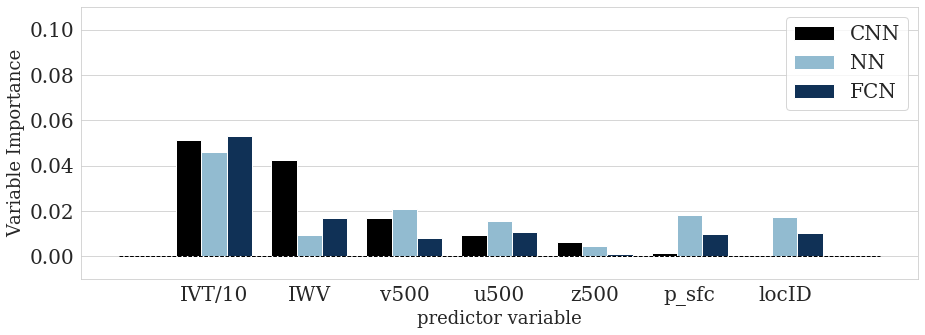

In [126]:
df_plot = pd.concat([df_plot_cnn,df_plot_nn,df_plot_fcn])
plt.figure(figsize=(15,5))
ax = sns.barplot(x="variable", y="twCRPS", hue="method", data=df_plot,ci=0,palette=SScolors)
plt.xticks(fontsize=20)
plt.xlabel('predictor variable', fontsize=18)
plt.ylabel('Variable Importance', fontsize=18)
plt.legend(fontsize=20)
plt.yticks(fontsize=20)
plt.plot([-1,7],[0,0],'k--',linewidth=1)
plt.ylim([-0.01,.11])
plt.locator_params(axis="y", nbins=8)
plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Permutation_'+fcast+'.png',dpi = 300,bbox_inches='tight')
plt.show()

In [127]:
fcast

'F120'